In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Load Raw Data
raw_path = "../data/raw/predictive_maintenance.csv"
df = pd.read_csv(raw_path)

In [3]:
# Clean Column Names (Standardize to snake_case)
df.columns = [col.replace('[K]', '').replace('[rpm]', '').replace('[Nm]', '').replace('[min]', '')
              .strip().replace(' ', '_').lower() for col in df.columns]

# Drop ID columns (UDI, Product ID) as they are not features
df = df.drop(columns=['udi', 'product_id'])

In [4]:
print(f"Raw Data Shape: {df.shape}")
df.head()

Raw Data Shape: (10000, 12)


,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear,machine_failure,twf,hdf,pwf,osf,rnf
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [5]:
drop_cols = ['machine_failure', 'twf', 'hdf', 'pwf', 'osf', 'rnf']
X = df.drop(columns=drop_cols)
y = df['machine_failure']

In [6]:
# Stratified Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train Shape: {X_train.shape}")
print(f"Test Shape:  {X_test.shape}")

# Check if the ratio of failures is preserved
train_fail_ratio = y_train.mean() * 100
test_fail_ratio = y_test.mean() * 100

print(f"Failure Rate in Train: {train_fail_ratio:.2f}%")
print(f"Failure Rate in Test:  {test_fail_ratio:.2f}%")

Train Shape: (8000, 6)
Test Shape:  (2000, 6)
Failure Rate in Train: 3.39%
Failure Rate in Test:  3.40%


In [7]:
def add_features(data):
    df_eng = data.copy()
    
    # 1. Temperature Difference (Process - Air)
    # Heat dissipation failures happen when this difference is low
    df_eng['temp_difference'] = df_eng['process_temperature'] - df_eng['air_temperature']
    
    # 2. Power Factor (Torque * Speed)
    # Power constraint violations
    df_eng['power_factor'] = df_eng['torque'] * df_eng['rotational_speed']
    
    # 3. Strain * Wear (Torque * Tool Wear)
    # Overstrain failures often happen with high torque AND worn tools
    df_eng['strain_wear_product'] = df_eng['torque'] * df_eng['tool_wear']
    
    return df_eng

# Apply to Train and Test
X_train_eng = add_features(X_train)
X_test_eng = add_features(X_test)

X_train_eng.head()

,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear,temp_difference,power_factor,strain_wear_product
4058,M,302.0,310.9,1456,47.2,54,8.9,68723.2,2548.8
1221,M,297.0,308.3,1399,46.4,132,11.3,64913.6,6124.8
6895,M,301.0,311.6,1357,45.6,137,10.6,61879.2,6247.2
9863,L,298.9,309.8,1411,56.3,84,10.9,79439.3,4729.2
8711,L,297.1,308.5,1733,28.7,50,11.4,49737.1,1435.0


In [8]:
# Define the mapping
type_map = {'L': 0, 'M': 1, 'H': 2}

# Apply mapping
X_train_eng['type'] = X_train_eng['type'].map(type_map)
X_test_eng['type'] = X_test_eng['type'].map(type_map)

print("Encoded 'type' column:")
print(X_train_eng['type'].value_counts())

Encoded 'type' column:
type
0    4830
1    2381
2     789
Name: count, dtype: int64


/tmp/ipykernel_21935/4059510089.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')


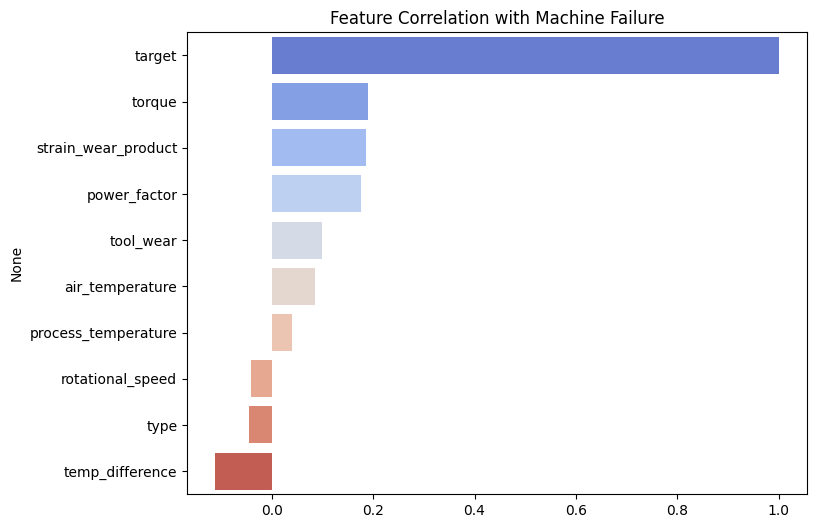

In [9]:
# Combine X and y temporarily just for correlation check
train_check = X_train_eng.copy()
train_check['target'] = y_train

# Correlation with target
correlations = train_check.corr()['target'].sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
plt.title("Feature Correlation with Machine Failure")
plt.show()

In [10]:
# Combine features and target for saving
train_processed = X_train_eng.copy()
train_processed['machine_failure'] = y_train

test_processed = X_test_eng.copy()
test_processed['machine_failure'] = y_test

# Define paths (relative to notebooks folder)
save_train_path = "../data/processed/train_engineered.csv"
save_test_path = "../data/processed/test_engineered.csv"

# Save
train_processed.to_csv(save_train_path, index=False)
test_processed.to_csv(save_test_path, index=False)

print(f"✅ Processed Train data saved to: {save_train_path} ({train_processed.shape})")
print(f"✅ Processed Test data saved to:  {save_test_path} ({test_processed.shape})")

✅ Processed Train data saved to: ../data/processed/train_engineered.csv ((8000, 10))
✅ Processed Test data saved to:  ../data/processed/test_engineered.csv ((2000, 10))
